In [20]:
import os
import time
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve


# Task 2: Analysis of results

### 0. Load data

In [5]:
print('Load data:')
start = time.time()
df = pd.read_parquet("MBD_mini/processed/data.parquet", engine="pyarrow")
print('\t- loaded {} in {:.2f} sec'.format(df.shape, time.time() - start))


Load data:
	- loaded (925679, 2274) in 54.06 sec


### 1. Validate models

In [17]:
def downsample(df, target_column, random_state=42):
    # print('Downsample:')
    
    ### Identify which class is a major/minor class
    class_counts = df[target_column].value_counts()
    majority_class = class_counts.idxmax()
    minority_class = class_counts.idxmin()
    
    df_majority = df[df[target_column] == majority_class]
    df_minority = df[df[target_column] == minority_class]
    # print('\t- df_majority:', df_majority.shape[0])
    # print('\t- df_minority:', df_minority.shape[0])

    ### Target number of samples
    # target_count = int((len(df_majority) + len(df_minority)) / 2) 
    target_count = len(df_minority) * 2

    ### Downsampling of majority_class
    df_majority_down = df_majority.sample(n=target_count, replace=False, random_state=random_state)
    # print('\t- downsampling ready:', df_majority_down.shape[0])
    
    ### Unite
    df_balanced = pd.concat([df_majority_down, df_minority])
    # print('\t- concat done:', df_balanced.shape[0])
    
    ### Shuffle
    df_balanced = df_balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)
    # print('\t- shuffled:', df_balanced.shape[0])
    
    return df_balanced


In [18]:
cols_to_ignore = [
    'client_id', 'mon',
    'trans_count', 'diff_trans_date'
]

target_cols = ['target_1', 'target_2', 'target_3', 'target_4']
features = [col for col in df.columns if col not in cols_to_ignore + target_cols]


In [19]:
N_FOLDS = 5
PATH = 'models/task2'
results = {}

for fold in range(5):
    folder_path = os.path.join(PATH, 'fold={}'.format(fold))
    
    results[fold] = {}
    print('-'*30)
    print(f"Fold {fold}")
    
    ### Get data 
    valid_df = df[df['fold'] == fold]
    
    print("\t- data was extracted")
    print('-'*30)
    
    for target in target_cols:
        results[fold][target] = {}
        print(f"\nValidation for: {target}")

        ### Upsample / Downsample
        valid_df_sampled = downsample(valid_df, target, random_state=42)
        
        ### Dataset
        X_valid = valid_df_sampled[features]
        y_valid = valid_df_sampled[target]

        ### Load model
        model_path = os.path.join(folder_path, f'model_target_{target}.txt')
        model = lgb.Booster(model_file=model_path)

        ### Predict
        preds = model.predict(X_valid, num_iteration=model.best_iteration)
        binary_preds = (preds > 0.5).astype(int)
        print("\t- prediction is finished")
        
        ### Metrics
        results[fold][target] = {
            'model': model,
            'auc': roc_auc_score(y_valid, preds),
            'accuracy': accuracy_score(y_valid, binary_preds),
            'precision': precision_score(y_valid, binary_preds),
            'recall': recall_score(y_valid, binary_preds),
            'f1': f1_score(y_valid, binary_preds),
            'cm': confusion_matrix(y_valid, binary_preds),
            'y_true': y_valid,       # Сохраняем истинные метки
            'preds': preds  
        }
        print("\t- metrics")
        for metric in ['auc', 'accuracy', 'precision', 'recall', 'f1']:
            val = results[fold][target][metric]
            print(f"\t\t- {metric}: {val}")
        

------------------------------
Fold 0
	- data was extracted
------------------------------

Validation for: target_1
	- prediction is finished
	- metrics
		- auc: 0.7688513321995465
		- accuracy: 0.6984126984126984
		- precision: 0.5346020761245674
		- recall: 0.7357142857142858
		- f1: 0.6192384769539078

Validation for: target_2
	- prediction is finished
	- metrics
		- auc: 0.7860107421875
		- accuracy: 0.65625
		- precision: 0.49
		- recall: 0.765625
		- f1: 0.5975609756097561

Validation for: target_3
	- prediction is finished
	- metrics
		- auc: 0.7655213988132812
		- accuracy: 0.6947565543071161
		- precision: 0.5306122448979592
		- recall: 0.7303370786516854
		- f1: 0.6146572104018913

Validation for: target_4
	- prediction is finished
	- metrics
		- auc: 0.8242361465333894
		- accuracy: 0.7662636729994243
		- precision: 0.6375198728139905
		- recall: 0.6925734024179621
		- f1: 0.6639072847682119
------------------------------
Fold 1
	- data was extracted
-----------------------

#### 1.1 Mean & std metrics among all folders

In [21]:
metric_names = ['auc', 'accuracy', 'precision', 'recall', 'f1']

targets = set()
for fold in results:
    for target in results[fold]:
        targets.add(target)


aggregated_results = {}

for target in targets:
    metrics = {metric: [] for metric in metric_names}
    
    for fold in results:
        if target in results[fold]:
            for metric in metric_names:
                metrics[metric].append(results[fold][target][metric])
    
    ### Calc mean and std
    aggregated_results[target] = {}
    for metric in metric_names:
        values = np.array(metrics[metric])
        aggregated_results[target][metric] = {
            'mean': np.mean(values),
            'std': np.std(values)
        }

for target, metrics in aggregated_results.items():
    print(f"Target: {target}")
    for metric, stats in metrics.items():
        print(f"  {metric}: mean = {stats['mean']:.4f}, std = {stats['std']:.4f}")
    print('---')


Target: target_4
  auc: mean = 0.8367, std = 0.0100
  accuracy: mean = 0.7764, std = 0.0054
  precision: mean = 0.6503, std = 0.0065
  recall: mean = 0.7120, std = 0.0193
  f1: mean = 0.6796, std = 0.0104
---
Target: target_2
  auc: mean = 0.8215, std = 0.0215
  accuracy: mean = 0.7257, std = 0.0367
  precision: mean = 0.5753, std = 0.0471
  recall: mean = 0.7260, std = 0.0504
  f1: mean = 0.6392, std = 0.0278
---
Target: target_1
  auc: mean = 0.7656, std = 0.0041
  accuracy: mean = 0.6921, std = 0.0112
  precision: mean = 0.5277, std = 0.0128
  recall: mean = 0.7314, std = 0.0220
  f1: mean = 0.6129, std = 0.0132
---
Target: target_3
  auc: mean = 0.7814, std = 0.0083
  accuracy: mean = 0.7115, std = 0.0103
  precision: mean = 0.5502, std = 0.0120
  recall: mean = 0.7391, std = 0.0074
  f1: mean = 0.6308, std = 0.0103
---


#### 1.2 ROC curves

In [42]:
targets = set()
for fold in results:
    for target in results[fold]:
        targets.add(target)
targets = sorted(targets)

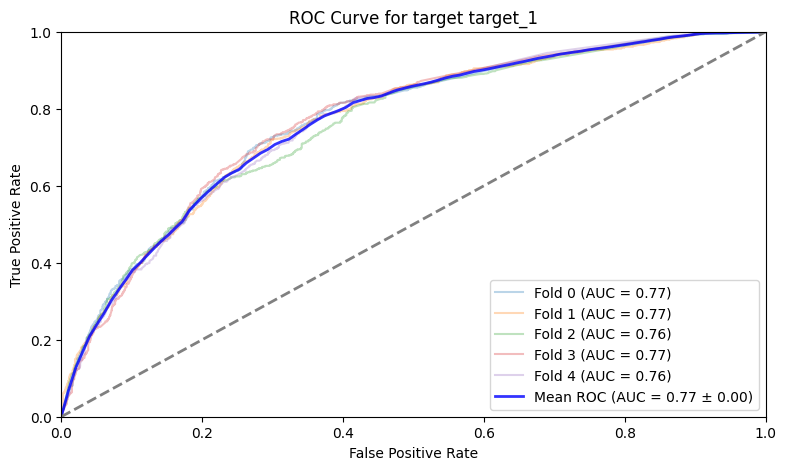

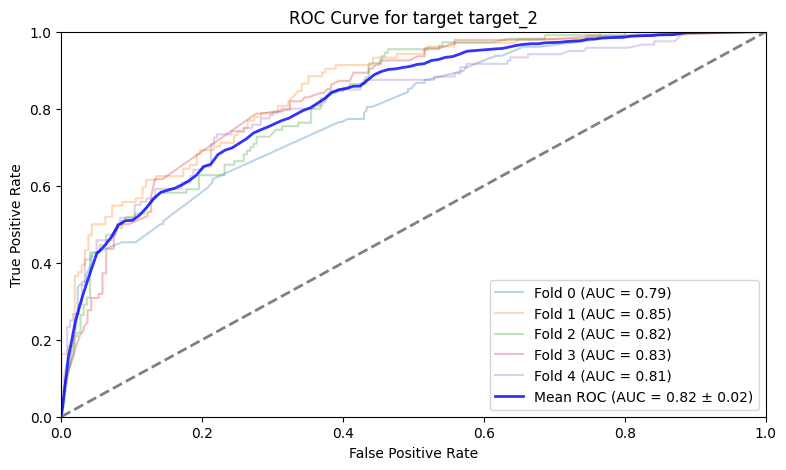

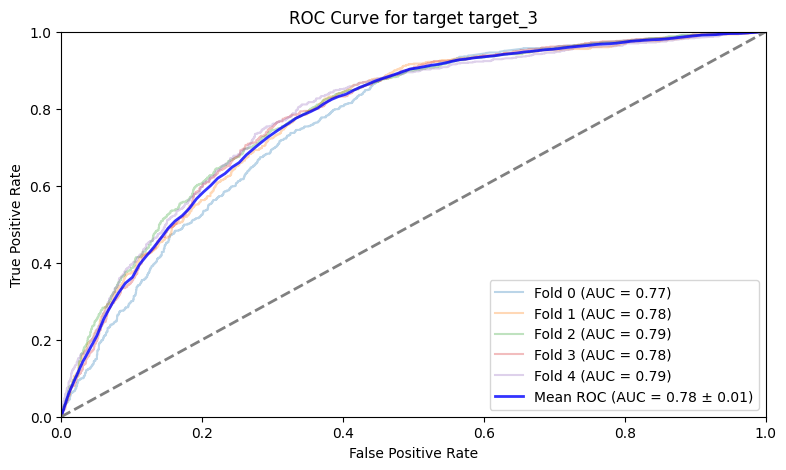

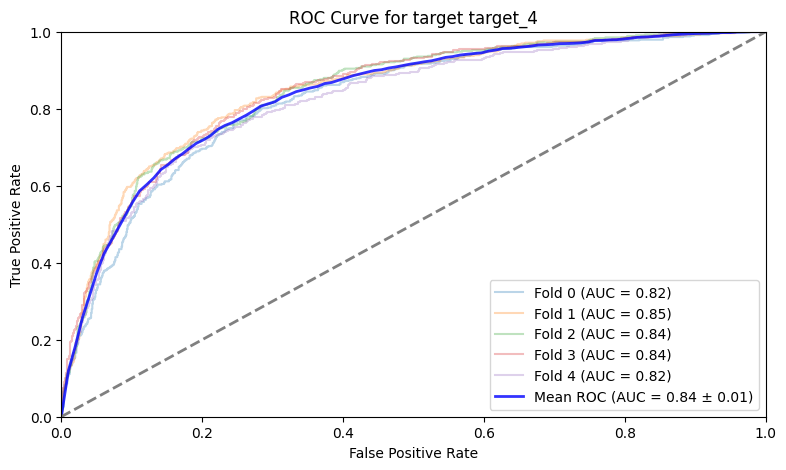

In [29]:
for target in targets:

    plt.figure(figsize=(20, 5))
    ax1 = plt.subplot(1, 2, 1)
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    
    for fold in results:
        if target in results[fold]:
            y_true = results[fold][target]['y_true']
            y_score = results[fold][target]['preds']
            fpr, tpr, _ = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(roc_auc)
            ax1.plot(fpr, tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax1.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2, alpha=0.8)
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'ROC Curve for target {target}')
    ax1.legend(loc='lower right')



#### 1.3 Precision-Recall Curves

In [ ]:
targets = set()
for fold in results:
    for target in results[fold]:
        targets.add(target)
targets = sorted(targets)

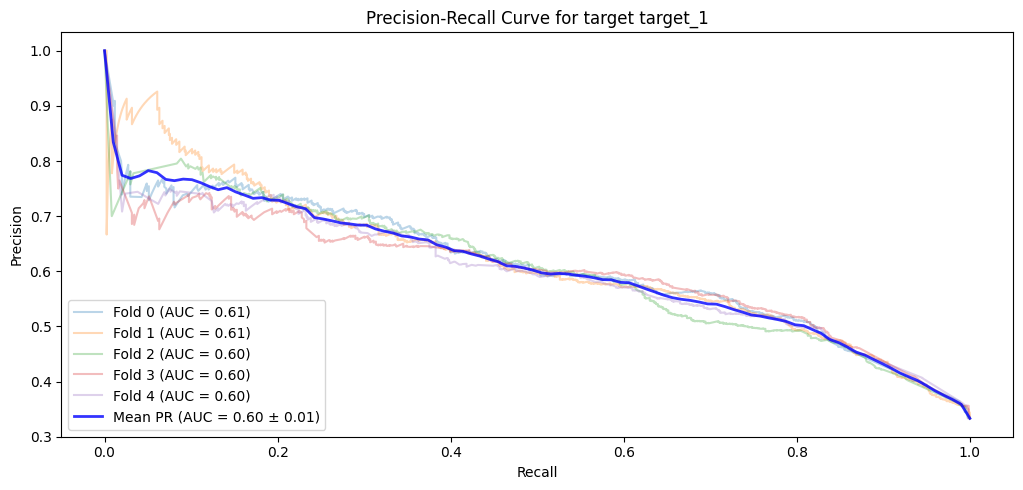

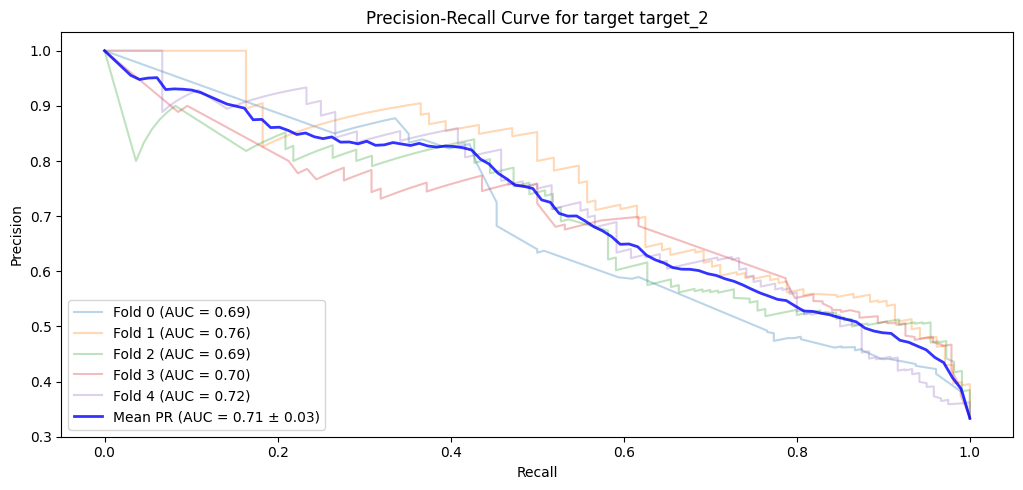

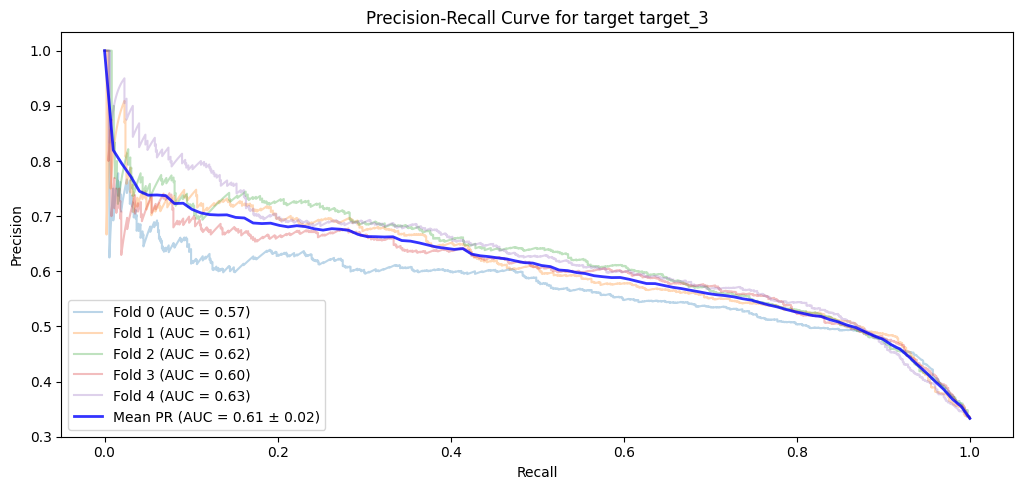

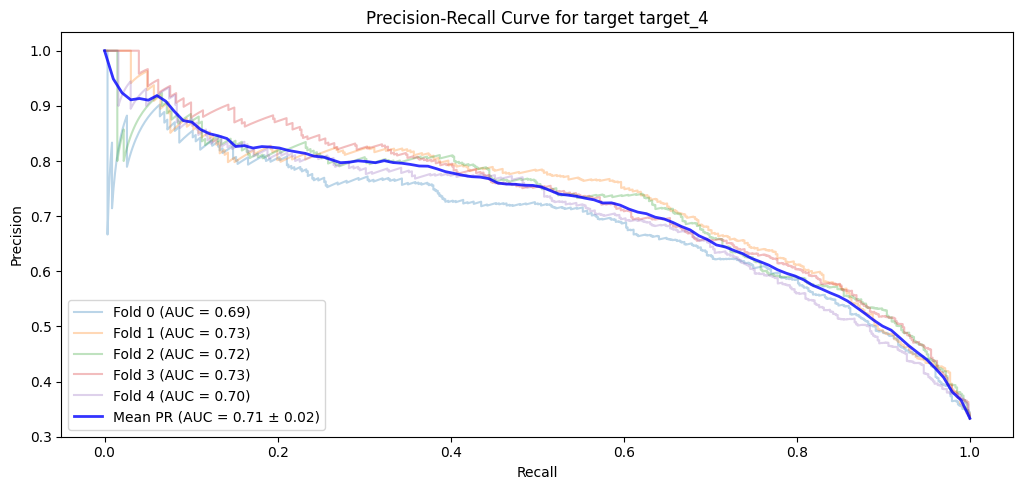

In [36]:
for target in targets:   
    #### Precision-Recall curve 
    plt.figure(figsize=(20, 5))
    
    ax2 = plt.subplot(1, 2, 1)
    mean_recall = np.linspace(0, 1, 100)
    interp_precisions = []
    pr_aucs = []
    
    for fold in results:
        if target in results[fold]:
            y_true = results[fold][target]['y_true']
            y_score = results[fold][target]['preds']
            precision, recall, _ = precision_recall_curve(y_true, y_score)
            pr_auc = auc(recall, precision)
            pr_aucs.append(pr_auc)
            
            interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
            interp_precisions.append(interp_precision)
            ax2.plot(recall, precision, alpha=0.3, label=f'Fold {fold} (AUC = {pr_auc:.2f})')
    
    mean_precision = np.mean(interp_precisions, axis=0)
    mean_pr_auc = auc(mean_recall, mean_precision)
    std_pr_auc = np.std(pr_aucs)
    ax2.plot(mean_recall, mean_precision, color='b', label=f'Mean PR (AUC = {mean_pr_auc:.2f} ± {std_pr_auc:.2f})', lw=2, alpha=0.8)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'Precision-Recall Curve for target {target}')
    ax2.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

#### 1.4 Optimal threshold: F1-score

In [ ]:
def find_optimal_threshold(y_true, y_probs, metric=f1_score, thresholds=np.linspace(0, 1, 101)):
    best_thresh = 0.5
    best_score = 0
    scores = []
    
    for thresh in thresholds:
        y_pred = (y_probs > thresh).astype(int)
        score = metric(y_true, y_pred)
        scores.append(score)
        if score > best_score:
            best_score = score
            best_thresh = thresh
    return best_thresh, best_score, scores


In [39]:
### Get optimal thresholds for each model & target
optimal_thresholds = {}  
for fold in results:
    for target in results[fold]:
        y_true = results[fold][target]['y_true']
        y_probs = results[fold][target]['preds']
        opt_thresh, best_f1, _ = find_optimal_threshold(y_true, y_probs, metric=f1_score)
        
        if target not in optimal_thresholds:
            optimal_thresholds[target] = {}
        optimal_thresholds[target][fold] = {'threshold': opt_thresh, 'f1': best_f1}
        print(f"Fold: {fold}, Target: {target} -> Optimal t: {opt_thresh:.2f}, Best F1: {best_f1:.4f}")


Fold: 0, Target: target_1 -> Optimal t: 0.45, Best F1: 0.6255
Fold: 0, Target: target_2 -> Optimal t: 0.50, Best F1: 0.5976
Fold: 0, Target: target_3 -> Optimal t: 0.36, Best F1: 0.6300
Fold: 0, Target: target_4 -> Optimal t: 0.44, Best F1: 0.6769
Fold: 1, Target: target_1 -> Optimal t: 0.44, Best F1: 0.6205
Fold: 1, Target: target_2 -> Optimal t: 0.37, Best F1: 0.6840
Fold: 1, Target: target_3 -> Optimal t: 0.42, Best F1: 0.6411
Fold: 1, Target: target_4 -> Optimal t: 0.47, Best F1: 0.6972
Fold: 2, Target: target_1 -> Optimal t: 0.41, Best F1: 0.6075
Fold: 2, Target: target_2 -> Optimal t: 0.38, Best F1: 0.6581
Fold: 2, Target: target_3 -> Optimal t: 0.42, Best F1: 0.6404
Fold: 2, Target: target_4 -> Optimal t: 0.52, Best F1: 0.6838
Fold: 3, Target: target_1 -> Optimal t: 0.47, Best F1: 0.6289
Fold: 3, Target: target_2 -> Optimal t: 0.50, Best F1: 0.6727
Fold: 3, Target: target_3 -> Optimal t: 0.46, Best F1: 0.6432
Fold: 3, Target: target_4 -> Optimal t: 0.46, Best F1: 0.6906
Fold: 4,

In [41]:
### Aggregated results 
aggregated_thresholds = {}
for target in optimal_thresholds:
    thresholds = []
    f1_scores = []
    for fold in optimal_thresholds[target]:
        thresholds.append(optimal_thresholds[target][fold]['threshold'])
        f1_scores.append(optimal_thresholds[target][fold]['f1'])
    aggregated_thresholds[target] = {
        'mean_threshold': np.mean(thresholds),
        'std_threshold': np.std(thresholds),
        'mean_f1': np.mean(f1_scores),
        'std_f1': np.std(f1_scores)
    }

print("Aggregated thresholds:")
for target, agg in aggregated_thresholds.items():
    print(f"Target: {target}")
    print(f"  Mean threshold: {agg['mean_threshold']:.2f} ± {agg['std_threshold']:.2f}")
    print(f"  Mean F1: {agg['mean_f1']:.4f} ± {agg['std_f1']:.4f}")


Aggregated thresholds:
Target: target_1
  Mean threshold: 0.44 ± 0.02
  Mean F1: 0.6206 ± 0.0073
Target: target_2
  Mean threshold: 0.45 ± 0.06
  Mean F1: 0.6563 ± 0.0305
Target: target_3
  Mean threshold: 0.42 ± 0.03
  Mean F1: 0.6408 ± 0.0062
Target: target_4
  Mean threshold: 0.48 ± 0.03
  Mean F1: 0.6844 ± 0.0086


#### 1.5 Features importance

In [ ]:
### Calculate for all targets & folds
feature_importances = {}

for fold in results:
    for target in results[fold]:
        model = results[fold][target]['model']

        features_names = model.feature_name()
        importances = model.feature_importance(importance_type='gain')

        df_imp = pd.DataFrame({
            'feature': features_names,
            'importance': importances
        })
        df_imp['fold'] = fold
        df_imp['target'] = target
        
        if target not in feature_importances:
            feature_importances[target] = []
        feature_importances[target].append(df_imp)



Features importance: target_1
                        feature           mean           std
1762  trx_event_subtype_52_mean  189988.435770  79233.063101
1854     trx_event_type_40_mean   58576.479314  72874.251470
235           dialog_avg_emb_31   41637.004592  28629.145959
1763   trx_event_subtype_52_sum   32096.245579  44645.916926
1948    trx_src_type11_35.0_sum   23958.575087   9165.484734
1961   trx_src_type12_47.0_mean   15663.729522   5439.052466
2044    trx_src_type22_29.0_sum   13814.757314   4979.230387
1677   trx_event_subtype_10_sum   13782.695586   4485.050103
1947   trx_src_type11_35.0_mean   13196.101460   6391.661974
1932           trx_recency_days   12477.867426  12671.585462
780         dialog_recency_days   11170.088160   4395.629944
80           dialog_avg_emb_170    9232.101197  17068.161150
439          dialog_avg_emb_494    9121.867662  20079.833884
344          dialog_avg_emb_408    9026.751465  20184.429891
1730  trx_event_subtype_37_mean    7672.174631   6266.

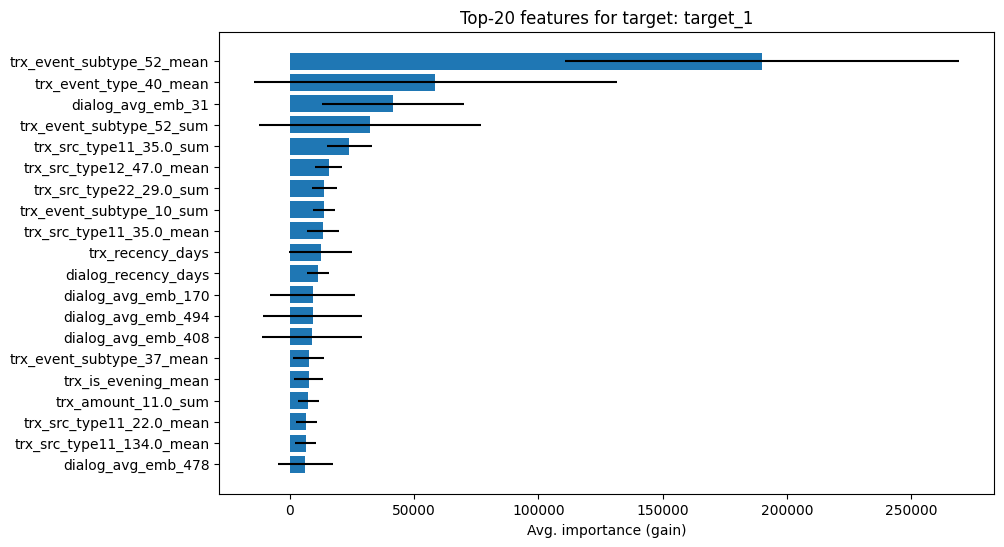


Features importance: target_2
                        feature          mean           std
1962    trx_src_type12_47.0_sum  46258.289161  36536.379124
1871      trx_event_type_48_sum   7701.027966  10894.884105
1951   trx_src_type12_-1.0_mean   5708.395924   6994.568525
1676  trx_event_subtype_10_mean   5189.411668   8876.999900
1677   trx_event_subtype_10_sum   4775.512605   3910.106836
1961   trx_src_type12_47.0_mean   4211.649830   2626.128336
1946    trx_src_type11_22.0_sum   4208.184134   5215.535213
1562       trx_amount_11.0_mean   3754.062594   2923.340210
1870     trx_event_type_48_mean   3494.243340   4683.026856
2108     trx_src_type22_8.0_sum   3492.815549   2982.897833
1565        trx_amount_11.0_sum   2275.950442   2718.387927
1564        trx_amount_11.0_std   2186.738574   1597.946728
2212    trx_src_type32_25.0_sum   1729.247351   1579.660698
1952    trx_src_type12_-1.0_sum   1295.805275   2174.267758
2092    trx_src_type22_66.0_sum   1146.162981   1282.435418
235      

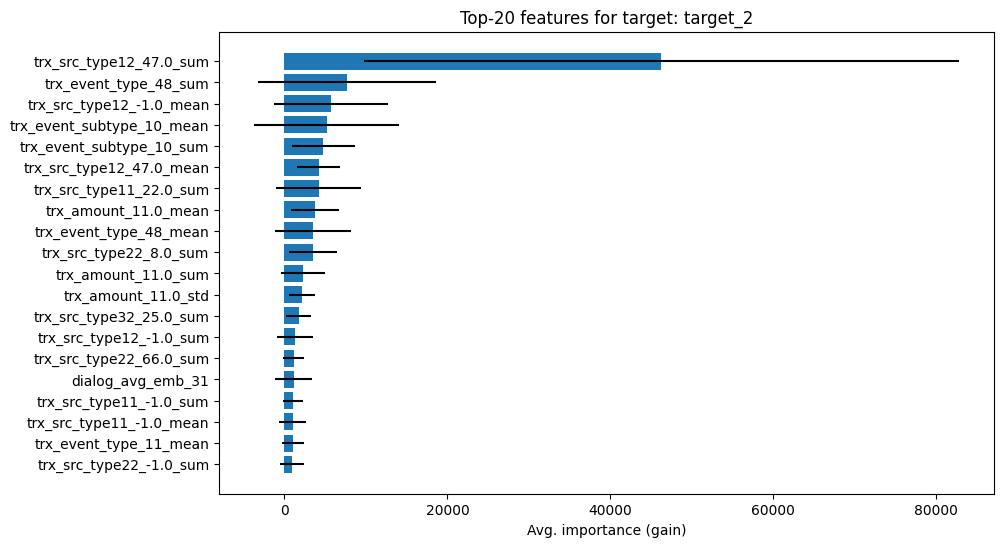


Features importance: target_3
                         feature           mean           std
1855       trx_event_type_40_sum  239310.230324  61660.232591
1763    trx_event_subtype_52_sum   82242.880854  61524.882614
1854      trx_event_type_40_mean   73581.754550  32291.956897
1762   trx_event_subtype_52_mean   62277.104765  58392.180258
1565         trx_amount_11.0_sum   38635.149710   8334.739995
1945    trx_src_type11_22.0_mean   32730.618987  11822.592766
1932            trx_recency_days   29032.127688   7601.611262
1628  trx_dst_type11_1569.0_mean   28189.594477   5851.623579
1788    trx_event_subtype_9_mean   26765.720730   8032.166433
1947    trx_src_type11_35.0_mean   23144.739816   4184.061905
570           dialog_avg_emb_611   19369.224522  20637.773230
2054     trx_src_type22_38.0_sum   19240.908539   4207.995083
1634     trx_dst_type11_5.0_mean   13342.568972   3765.551929
1986     trx_src_type21_-1.0_sum   12203.056058   9329.148132
235            dialog_avg_emb_31   1172

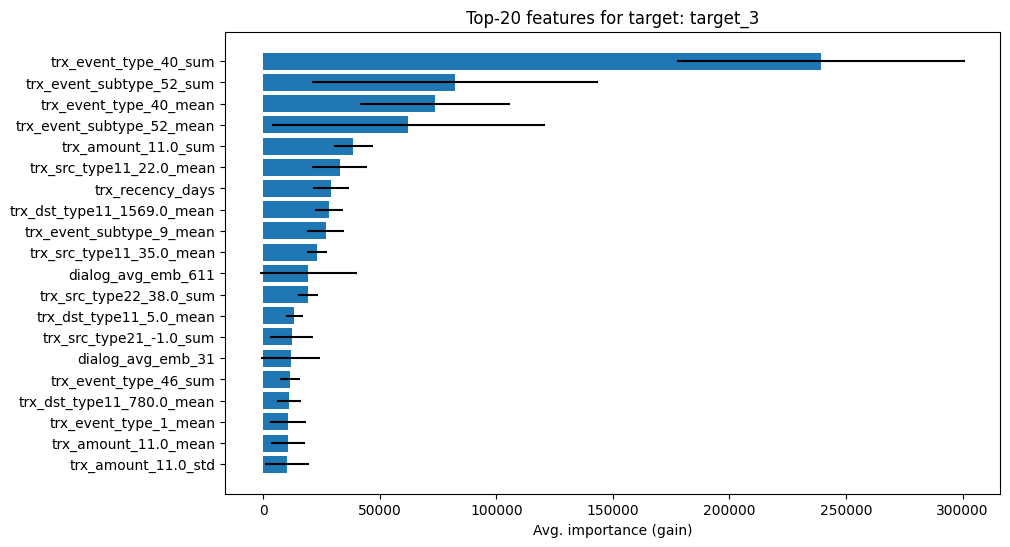


Features importance: target_4
                          feature          mean           std
2214      trx_src_type32_26.0_sum  97396.820216   6461.368124
1962      trx_src_type12_47.0_sum  94165.702601  42553.315472
2222      trx_src_type32_36.0_sum  74505.998604   2031.891953
1946      trx_src_type11_22.0_sum  54787.335872  43199.803969
2066      trx_src_type22_46.0_sum  40768.656506   2300.904826
1649   trx_dst_type12_16067.0_sum  36023.969813  21120.015865
2250      trx_src_type32_69.0_sum  35779.520582   3320.547746
1665   trx_dst_type12_26766.0_sum  24549.443555  12418.390804
1652  trx_dst_type12_18855.0_mean  22667.268563   5695.400719
1854       trx_event_type_40_mean  19639.828852  32347.417573
1648  trx_dst_type12_16067.0_mean  19411.385447   6640.964479
2124      trx_src_type31_-1.0_sum  18946.858586   4821.412781
2213     trx_src_type32_26.0_mean  17307.937045   3941.300379
1855        trx_event_type_40_sum  16372.370269  11241.156955
303            dialog_avg_emb_371  1582

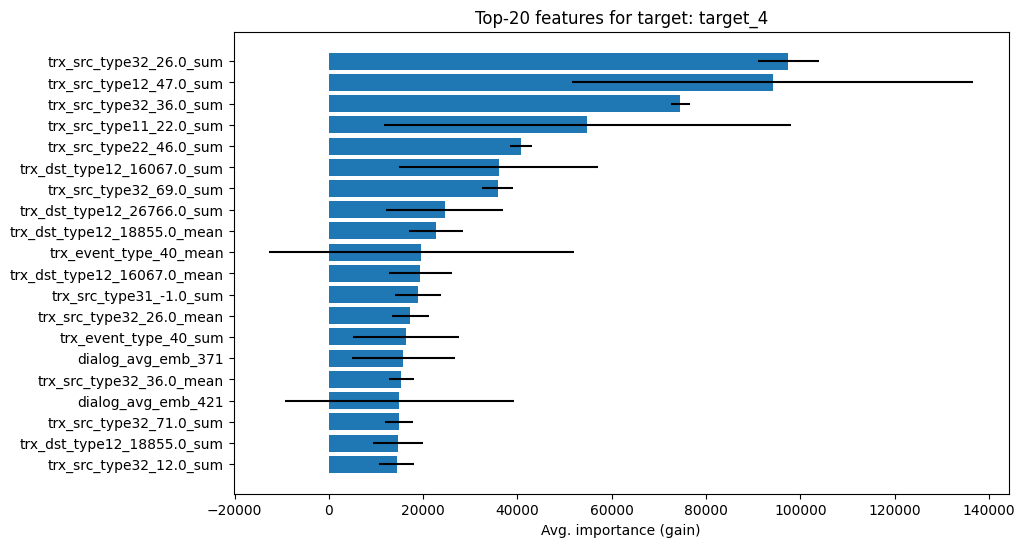

In [52]:
### Aggregate over folds
aggregated_importances = {}

for target, dfs in feature_importances.items():

    df_all = pd.concat(dfs, axis=0)
    agg_df = df_all.groupby('feature')['importance'].agg(['mean', 'std']).reset_index()
    agg_df = agg_df.sort_values(by='mean', ascending=False)
    aggregated_importances[target] = agg_df

    print(f"\nFeatures importance: {target}")
    print(agg_df.head(20))

    plt.figure(figsize=(10,6))
    plt.barh(agg_df['feature'].head(20)[::-1], agg_df['mean'].head(20)[::-1], xerr=agg_df['std'].head(20)[::-1])
    plt.xlabel('Avg. importance (gain)')
    plt.title(f'Top-20 features for target: {target}')
    plt.show()


In [54]:
# aggregated_importances


Features importance: 
                          feature          mean
1855        trx_event_type_40_sum  65489.280280
1762    trx_event_subtype_52_mean  63509.956267
1962      trx_src_type12_47.0_sum  38268.851014
1854       trx_event_type_40_mean  38056.027860
1763     trx_event_subtype_52_sum  28649.409429
2214      trx_src_type32_26.0_sum  24423.802956
2222      trx_src_type32_36.0_sum  18721.351266
1946      trx_src_type11_22.0_sum  16649.919566
235             dialog_avg_emb_31  14190.429746
1565          trx_amount_11.0_sum  13696.413643
1932             trx_recency_days  13480.207558
1945     trx_src_type11_22.0_mean  10518.640167
2066      trx_src_type22_46.0_sum  10214.156401
1947     trx_src_type11_35.0_mean   9369.654344
1649   trx_dst_type12_16067.0_sum   9340.853269
2250      trx_src_type32_69.0_sum   9025.222776
1948      trx_src_type11_35.0_sum   7848.199847
1628   trx_dst_type11_1569.0_mean   7642.255687
1652  trx_dst_type12_18855.0_mean   7512.964629
1788     trx_even

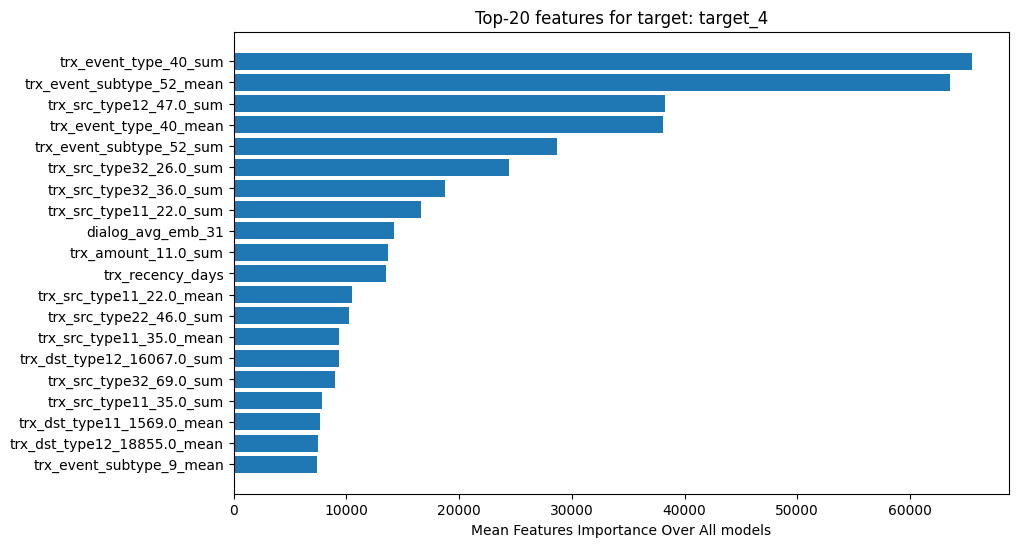

In [67]:
### Aggregate over all models
aggregated_importances_all = {}

dfs = []
for target, df in aggregated_importances.items():
    dfs.append(df)

df_all = pd.concat(dfs, axis=0)
agg_all_df = df_all.groupby('feature')['mean'].agg(['mean']).reset_index()
agg_all_df = agg_all_df.sort_values(by='mean', ascending=False)

print(f"\nFeatures importance: ")
print(agg_all_df.head(20))

plt.figure(figsize=(10,6))
plt.barh(agg_all_df['feature'].head(20)[::-1], agg_all_df['mean'].head(20)[::-1], )
plt.xlabel('Mean Features Importance Over All models')
plt.title(f'Top-20 features for target: {target}')
plt.show()


#### 1.6 Confusion matrices

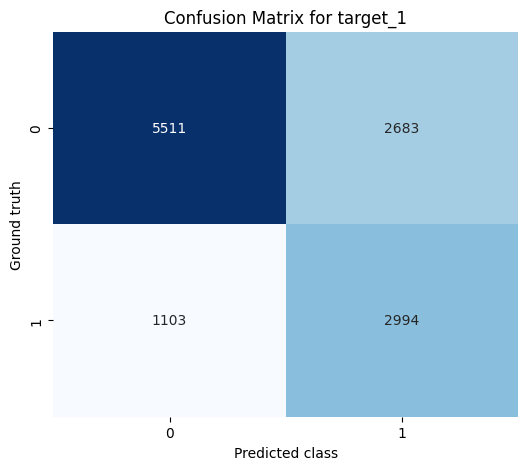

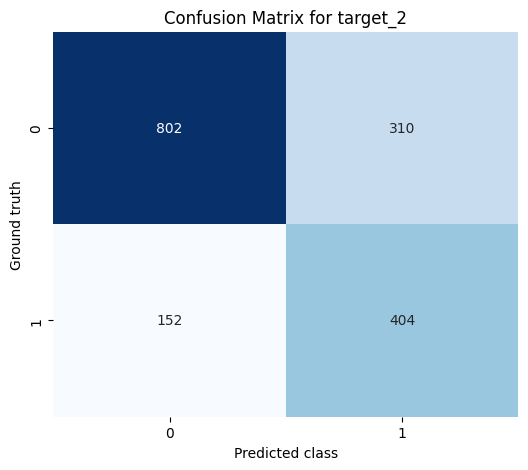

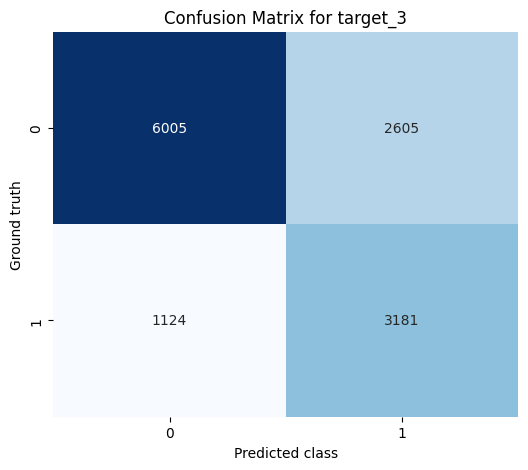

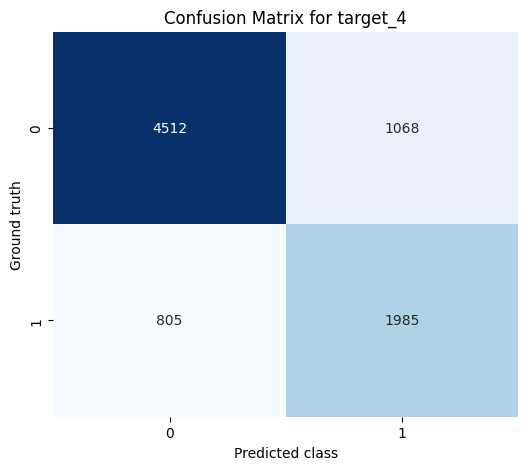

In [51]:
aggregated_cm = {}

for fold in results:
    for target in results[fold]:
        cm = np.array(results[fold][target]['cm'])
        if target not in aggregated_cm:
            aggregated_cm[target] = cm.copy() 
        else:
            aggregated_cm[target] += cm  

for target, cm in aggregated_cm.items():
    # print(target, cm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted class")
    plt.ylabel("Ground truth")
    plt.title(f"Confusion Matrix for {target}")
    plt.show()


### 2. Conclusion
Based on the cross-validation results for four targets, 
- Target 4 achieves the highest AUC (0.8367 ± 0.0100) and the highest F1 score (0.6796 ± 0.0104), indicating relatively strong discriminative power.
- Target 2 also shows a good AUC (0.8215 ± 0.0215) but exhibits higher variance across folds (accuracy ranging from around 69% to 76%), suggesting it may require further tuning or additional features.
- Meanwhile, Target 1 and Target 3 have slightly lower AUC values (0.7656 and 0.7814, respectively), with F1 scores around 0.61–0.63, indicating moderate classification performance.

Regarding **optimal thresholds** (selected to maximize F1):

- Target 1 has a mean threshold of 0.44 ± 0.02, yielding a mean F1 of 0.6206 ± 0.0073.
- Target 2 has a mean threshold of 0.45 ± 0.06, with an F1 of 0.6563 ± 0.0305.
- Target 3 has a mean threshold of 0.42 ± 0.03, reaching an F1 of 0.6408 ± 0.0062.
- Target 4 has a mean threshold of 0.48 ± 0.03, giving an F1 of 0.6844 ± 0.0086.

From the **top features** listed for each target, we can observe a recurring theme: specific transaction types, subtypes and specific sender/reciever features appear to be key drivers of the model’s predictions. 

Overall, the models demonstrate moderate to good performance, with Target 4 performing best on average. However, each target still shows room for improvement in both stability and accuracy, indicating that further feature engineering, hyperparameter tuning, or balancing techniques may be beneficial.